In this notebook you can train a student through DAgger for [reacher](https://gymnasium.farama.org/environments/mujoco/reacher/) environment. You should set:
- `seed`: For reproducibility of training runs

In [1]:
#@title Inizialization and import

import shutil
shutil.rmtree('DAgger4Robotics', ignore_errors=True)
!git clone "https://github.com/cybernetic-m/DAgger4Robotics.git"
!pip install "gymnasium[mujoco]" -q
!apt-get install -y xvfb ffmpeg -q
!pip install pyvirtualdisplay imageio -q
!pip install gymnasium-robotics -q #Needed for Simulator
!pip install "minari[all]" -q


import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import torch
import torch.nn as nn
import json
import os
import numpy as np
import minari # needed for dataset
import matplotlib.pyplot as plt


from DAgger4Robotics.model.NetworkInterface import NetworkInterface
from DAgger4Robotics.dagger.DAgger import DAgger
from DAgger4Robotics.simulator.Simulator import Simulator


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Reproducibility instructions
seed=42 #@param {type:"integer"}
np.random.seed(seed)                   # NumPy
torch.manual_seed(seed)                # PyTorch CPU
torch.cuda.manual_seed(seed)           # PyTorch GPU
torch.cuda.manual_seed_all(seed)       # All GPUs

torch.backends.cudnn.deterministic = True   # Deterministic behaviour
torch.backends.cudnn.benchmark = False      # Avoid non-deterministic optimizations

# Dimensions of the problem
state_dim = 10
action_dim = 2

Cloning into 'DAgger4Robotics'...
remote: Enumerating objects: 861, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 861 (delta 52), reused 18 (delta 4), pack-reused 768 (from 1)
Receiving objects: 100% (861/861), 163.21 MiB | 33.92 MiB/s, done.
Resolving deltas: 100% (330/330), done.
Updating files: 100% (257/257), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 21.6 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━

**THIS DATASET IS USED ONLY FOR EVALUATION**

In [2]:
#@title Loading dataset
dataset_type = 'expert'

validation_dataset = minari.load_dataset(f'mujoco/reacher/{dataset_type}-v0',download=True)
validation_dataset.set_seed(seed)  # Set a seed for reproducibility
print("Dataset loaded successfully!")

#Using all the episodes to validate the new student
print(f"Validation episodes: {len(validation_dataset)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


namespace_metadata.json: 0.00B [00:00, ?B/s]

metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

namespace_metadata.json: 0.00B [00:00, ?B/s]

namespace_metadata.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

main_data.hdf5:   0%|          | 0.00/216M [00:00<?, ?B/s]


Dataset mujoco/reacher/expert-v0 downloaded to /root/.minari/datasets/mujoco/reacher/expert-v0
Dataset loaded successfully!
Validation episodes: 10000


### Training Student Hyperparameters
This part of code runs and tests the DAgger algorithm. You must set
- `batch_size`: Number of samples state-action per batch
- `lr`: Learning rate for the optimizer
- `num_epochs`: Number of training epochs
- `rollouts_per_iteration`: Number of generated episodes in each iteration of DAgger
- `n_iterations`: Number of iteration of DAgger
- `betaMode`: The type of function that manages the decay of Beta. It can be `'inverse'`, `'linear'`, `'exponential'`
- `exponential_beta_k`: Exponent used in the beta function when betaMode is set to `'exponential'`
- `student_type`: It can be `'simple'` or `'deep'`, but generally `'simple'` for students

###Loading a different expert
If you want to use a different expert , you can load it manually by changing:
- `path_to_expert_model`: Insert here the complete path to the model provided by `Dagger4Robotics` folder
- `expert_type`: The architecture type of the loaded model (`"simple"` or `"deep"`)



In [ ]:
#@title Run the algorithm
loss_fn = nn.MSELoss()

# Hyperparameters for training the student
batch_size = 32 #@param {type:"integer"}
lr = 1e-3  #@param {type:"number"}
num_epochs = 5 #@param {type:"integer"}

# Number of generated episodes in each iteration of DAgger
rollouts_per_iteration=20 #@param {type:"integer"}

# Number of iteration of DAgger
n_iterations=20 #@param {type:"integer"}

# The type of function that manages the value of Beta. It can be 'inverse', 'linear', 'exponential'
betaMode = 'inverse' #@param ["inverse","linear","exponential"]

# Exponent used in the beta function when betaMode is set to 'exponential'
exponential_beta_k = 0.5 #@param {type:"number"}

# It can be 'simple' or 'deep, but generally 'simple' for students
student_type='simple' #@param ["simple","deep"]

# Initializing the student
net_wrapper = NetworkInterface(net_type=student_type,input_dim=state_dim,output_dim=action_dim)
net_wrapper.summary()
pi = net_wrapper.get_model().to(device)

# Loading pre-trained expert/teacher
path_to_expert_model='./DAgger4Robotics/experts_reacher/deep/reacher_expert_not_filtered/batch_size_128_lr_1e-4/expert_policy.pt'
expert_type='deep'
net_wrapper = NetworkInterface(net_type=expert_type,input_dim=state_dim,output_dim=action_dim)
net_wrapper.summary()
pi_star = net_wrapper.get_model().to(device)
pi_star.load_state_dict(torch.load(path_to_expert_model, map_location=device))
pi_star.eval()

env = gym.make("Reacher-v5")
optimizer = torch.optim.Adam(pi.parameters(), lr=lr)

# Initializing the DAgger algorithm
dagger = DAgger(env = env,
                env_type='reacher',
                validationDataset= validation_dataset,
                studentPolicy = pi,
                expertPolicy = pi_star,
                optimizer=optimizer,
                loss_fn = loss_fn,
                batch_size = batch_size,
                num_epochs = num_epochs,
                betaMode = betaMode,
                device = device,
                rollouts_per_iteration=rollouts_per_iteration,
                exponential_beta_k = exponential_beta_k
                )

# Running the training
dagger.run(n_iterations=n_iterations)

DeepPolicyNet(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)
DeepPolicyNet(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=2, bias=True)
  )
)
Validation Dataset correctly loaded.
Obs Space Dim: 500000, Action Space Dim: 500000
Run DAgger algorithm...

--- ITERATION 1/20 | beta = 1.000 ---
Rollout... 
The Expert was

Elements...: 100%|██████████| 32/32 [00:00<00:00, 362.28it/s]


TRAIN	 Loss: 0.00700716, RMSE: 0.08296500, MAE: 0.04875634, R2: 0.02487171
EPOCH 1:


Elements...: 100%|██████████| 32/32 [00:00<00:00, 382.17it/s]


TRAIN	 Loss: 0.00536398, RMSE: 0.07282919, MAE: 0.04096020, R2: 0.24461561
EPOCH 2:


Elements...: 100%|██████████| 32/32 [00:00<00:00, 328.08it/s]


TRAIN	 Loss: 0.00447662, RMSE: 0.06607465, MAE: 0.03580328, R2: 0.37638307
EPOCH 3:


Elements...: 100%|██████████| 32/32 [00:00<00:00, 333.88it/s]


TRAIN	 Loss: 0.00394084, RMSE: 0.06215268, MAE: 0.03265540, R2: 0.44713381
EPOCH 4:


Elements...: 100%|██████████| 32/32 [00:00<00:00, 381.21it/s]


TRAIN	 Loss: 0.00339717, RMSE: 0.05777221, MAE: 0.02979297, R2: 0.52161533
Model saved as student_policy_0.pt

--- ITERATION 2/20 | beta = 0.500 ---
Rollout... 
The Expert was selected 504 times, while the student was selected 496 times
Collected data - Observations: 2000 Actions: 2000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 63/63 [00:00<00:00, 456.50it/s]


TRAIN	 Loss: 0.00401150, RMSE: 0.06326585, MAE: 0.03810430, R2: 0.55726409
EPOCH 1:


Elements...: 100%|██████████| 63/63 [00:00<00:00, 459.39it/s]


TRAIN	 Loss: 0.00322950, RMSE: 0.05681681, MAE: 0.03441158, R2: 0.64275169
EPOCH 2:


Elements...: 100%|██████████| 63/63 [00:00<00:00, 443.48it/s]


TRAIN	 Loss: 0.00270824, RMSE: 0.05204152, MAE: 0.03109382, R2: 0.69998562
EPOCH 3:


Elements...: 100%|██████████| 63/63 [00:00<00:00, 429.93it/s]


TRAIN	 Loss: 0.00238587, RMSE: 0.04885723, MAE: 0.02900157, R2: 0.73536766
EPOCH 4:


Elements...: 100%|██████████| 63/63 [00:00<00:00, 444.84it/s]


TRAIN	 Loss: 0.00218025, RMSE: 0.04669509, MAE: 0.02755318, R2: 0.75829881
Model saved as student_policy_1.pt

--- ITERATION 3/20 | beta = 0.333 ---
Rollout... 
The Expert was selected 331 times, while the student was selected 669 times
Collected data - Observations: 3000 Actions: 3000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 94/94 [00:00<00:00, 262.85it/s]


TRAIN	 Loss: 0.00208601, RMSE: 0.04561658, MAE: 0.02923588, R2: 0.77089453
EPOCH 1:


Elements...: 100%|██████████| 94/94 [00:00<00:00, 441.07it/s]


TRAIN	 Loss: 0.00194083, RMSE: 0.04397390, MAE: 0.02817588, R2: 0.78693604
EPOCH 2:


Elements...: 100%|██████████| 94/94 [00:00<00:00, 441.12it/s]


TRAIN	 Loss: 0.00183801, RMSE: 0.04283026, MAE: 0.02719355, R2: 0.79734993
EPOCH 3:


Elements...: 100%|██████████| 94/94 [00:00<00:00, 248.23it/s]


TRAIN	 Loss: 0.00170238, RMSE: 0.04122469, MAE: 0.02624482, R2: 0.81225216
EPOCH 4:


Elements...: 100%|██████████| 94/94 [00:00<00:00, 429.57it/s]


TRAIN	 Loss: 0.00160020, RMSE: 0.03998237, MAE: 0.02546716, R2: 0.82297254
Model saved as student_policy_2.pt

--- ITERATION 4/20 | beta = 0.250 ---
Rollout... 
The Expert was selected 241 times, while the student was selected 759 times
Collected data - Observations: 4000 Actions: 4000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 125/125 [00:00<00:00, 436.63it/s]


TRAIN	 Loss: 0.00207830, RMSE: 0.04557259, MAE: 0.03131679, R2: 0.78557360
EPOCH 1:


Elements...: 100%|██████████| 125/125 [00:00<00:00, 431.24it/s]


TRAIN	 Loss: 0.00194451, RMSE: 0.04409268, MAE: 0.03020115, R2: 0.79994380
EPOCH 2:


Elements...: 100%|██████████| 125/125 [00:00<00:00, 422.02it/s]


TRAIN	 Loss: 0.00176672, RMSE: 0.04203155, MAE: 0.02875088, R2: 0.81851161
EPOCH 3:


Elements...: 100%|██████████| 125/125 [00:00<00:00, 435.56it/s]


TRAIN	 Loss: 0.00162002, RMSE: 0.04024925, MAE: 0.02759761, R2: 0.83368754
EPOCH 4:


Elements...: 100%|██████████| 125/125 [00:00<00:00, 433.77it/s]


TRAIN	 Loss: 0.00147738, RMSE: 0.03843662, MAE: 0.02615236, R2: 0.84852862
Model saved as student_policy_3.pt

--- ITERATION 5/20 | beta = 0.200 ---
Rollout... 
The Expert was selected 193 times, while the student was selected 807 times
Collected data - Observations: 5000 Actions: 5000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 157/157 [00:00<00:00, 438.52it/s]


TRAIN	 Loss: 0.00144053, RMSE: 0.03779482, MAE: 0.02593707, R2: 0.85192591
EPOCH 1:


Elements...: 100%|██████████| 157/157 [00:00<00:00, 428.16it/s]


TRAIN	 Loss: 0.00132678, RMSE: 0.03627411, MAE: 0.02492710, R2: 0.86357236
EPOCH 2:


Elements...: 100%|██████████| 157/157 [00:00<00:00, 439.90it/s]


TRAIN	 Loss: 0.00124692, RMSE: 0.03521261, MAE: 0.02414628, R2: 0.87127215
EPOCH 3:


Elements...: 100%|██████████| 157/157 [00:00<00:00, 433.18it/s]


TRAIN	 Loss: 0.00114937, RMSE: 0.03380238, MAE: 0.02303733, R2: 0.88138294
EPOCH 4:


Elements...: 100%|██████████| 157/157 [00:00<00:00, 422.54it/s]


TRAIN	 Loss: 0.00107806, RMSE: 0.03272806, MAE: 0.02221465, R2: 0.88878369
Model saved as student_policy_4.pt

--- ITERATION 6/20 | beta = 0.167 ---
Rollout... 
The Expert was selected 182 times, while the student was selected 818 times
Collected data - Observations: 6000 Actions: 6000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 188/188 [00:00<00:00, 431.36it/s]


TRAIN	 Loss: 0.00087887, RMSE: 0.02954480, MAE: 0.02083128, R2: 0.90912098
EPOCH 1:


Elements...: 100%|██████████| 188/188 [00:00<00:00, 331.80it/s]


TRAIN	 Loss: 0.00094249, RMSE: 0.03047957, MAE: 0.02087545, R2: 0.90367806
EPOCH 2:


Elements...: 100%|██████████| 188/188 [00:00<00:00, 371.14it/s]


TRAIN	 Loss: 0.00082460, RMSE: 0.02851825, MAE: 0.01939466, R2: 0.91565204
EPOCH 3:


Elements...: 100%|██████████| 188/188 [00:00<00:00, 354.82it/s]


TRAIN	 Loss: 0.00073338, RMSE: 0.02689870, MAE: 0.01825363, R2: 0.92494756
EPOCH 4:


Elements...: 100%|██████████| 188/188 [00:00<00:00, 329.62it/s]


TRAIN	 Loss: 0.00066463, RMSE: 0.02561382, MAE: 0.01732636, R2: 0.93193042
Model saved as student_policy_5.pt

--- ITERATION 7/20 | beta = 0.143 ---
Rollout... 
The Expert was selected 142 times, while the student was selected 858 times
Collected data - Observations: 7000 Actions: 7000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 219/219 [00:00<00:00, 438.06it/s]


TRAIN	 Loss: 0.00064247, RMSE: 0.02508919, MAE: 0.01758319, R2: 0.93702620
EPOCH 1:


Elements...: 100%|██████████| 219/219 [00:00<00:00, 437.94it/s]


TRAIN	 Loss: 0.00053585, RMSE: 0.02296518, MAE: 0.01601742, R2: 0.94712234
EPOCH 2:


Elements...: 100%|██████████| 219/219 [00:00<00:00, 434.86it/s]


TRAIN	 Loss: 0.00050790, RMSE: 0.02233148, MAE: 0.01548854, R2: 0.95006359
EPOCH 3:


Elements...: 100%|██████████| 219/219 [00:00<00:00, 434.26it/s]


TRAIN	 Loss: 0.00045658, RMSE: 0.02118865, MAE: 0.01464189, R2: 0.95501196
EPOCH 4:


Elements...: 100%|██████████| 219/219 [00:00<00:00, 445.91it/s]


TRAIN	 Loss: 0.00044941, RMSE: 0.02101258, MAE: 0.01432438, R2: 0.95577466
Model saved as student_policy_6.pt

--- ITERATION 8/20 | beta = 0.125 ---
Rollout... 
The Expert was selected 114 times, while the student was selected 886 times
Collected data - Observations: 8000 Actions: 8000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 250/250 [00:00<00:00, 418.74it/s]


TRAIN	 Loss: 0.00058157, RMSE: 0.02376500, MAE: 0.01566876, R2: 0.94222581
EPOCH 1:


Elements...: 100%|██████████| 250/250 [00:00<00:00, 435.72it/s]


TRAIN	 Loss: 0.00045829, RMSE: 0.02116356, MAE: 0.01392388, R2: 0.95407391
EPOCH 2:


Elements...: 100%|██████████| 250/250 [00:00<00:00, 428.72it/s]


TRAIN	 Loss: 0.00044326, RMSE: 0.02080712, MAE: 0.01362134, R2: 0.95562017
EPOCH 3:


Elements...: 100%|██████████| 250/250 [00:00<00:00, 435.31it/s]


TRAIN	 Loss: 0.00040952, RMSE: 0.02000936, MAE: 0.01313844, R2: 0.95893943
EPOCH 4:


Elements...: 100%|██████████| 250/250 [00:00<00:00, 445.93it/s]


TRAIN	 Loss: 0.00036833, RMSE: 0.01899374, MAE: 0.01253199, R2: 0.96296757
Model saved as student_policy_7.pt

--- ITERATION 9/20 | beta = 0.111 ---
Rollout... 
The Expert was selected 113 times, while the student was selected 887 times
Collected data - Observations: 9000 Actions: 9000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 282/282 [00:00<00:00, 438.86it/s]


TRAIN	 Loss: 0.00036193, RMSE: 0.01872604, MAE: 0.01254402, R2: 0.96366024
EPOCH 1:


Elements...: 100%|██████████| 282/282 [00:00<00:00, 434.15it/s]


TRAIN	 Loss: 0.00033242, RMSE: 0.01797187, MAE: 0.01202046, R2: 0.96651328
EPOCH 2:


Elements...: 100%|██████████| 282/282 [00:00<00:00, 436.31it/s]


TRAIN	 Loss: 0.00032921, RMSE: 0.01790473, MAE: 0.01183667, R2: 0.96674615
EPOCH 3:


Elements...: 100%|██████████| 282/282 [00:00<00:00, 349.36it/s]


TRAIN	 Loss: 0.00031711, RMSE: 0.01758216, MAE: 0.01170941, R2: 0.96791983
EPOCH 4:


Elements...: 100%|██████████| 282/282 [00:00<00:00, 360.49it/s]


TRAIN	 Loss: 0.00030701, RMSE: 0.01728539, MAE: 0.01144232, R2: 0.96901274
Model saved as student_policy_8.pt

--- ITERATION 10/20 | beta = 0.100 ---
Rollout... 
The Expert was selected 99 times, while the student was selected 901 times
Collected data - Observations: 10000 Actions: 10000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 313/313 [00:00<00:00, 428.25it/s]


TRAIN	 Loss: 0.00035305, RMSE: 0.01864007, MAE: 0.01232446, R2: 0.96363169
EPOCH 1:


Elements...: 100%|██████████| 313/313 [00:00<00:00, 436.70it/s]


TRAIN	 Loss: 0.00029934, RMSE: 0.01711936, MAE: 0.01110850, R2: 0.96940255
EPOCH 2:


Elements...: 100%|██████████| 313/313 [00:00<00:00, 434.60it/s]


TRAIN	 Loss: 0.00030490, RMSE: 0.01730904, MAE: 0.01122294, R2: 0.96866810
EPOCH 3:


Elements...: 100%|██████████| 313/313 [00:00<00:00, 437.31it/s]


TRAIN	 Loss: 0.00027273, RMSE: 0.01638086, MAE: 0.01071445, R2: 0.97191823
EPOCH 4:


Elements...: 100%|██████████| 313/313 [00:00<00:00, 434.27it/s]


TRAIN	 Loss: 0.00025725, RMSE: 0.01590069, MAE: 0.01039575, R2: 0.97355390
Model saved as student_policy_9.pt

--- ITERATION 11/20 | beta = 0.091 ---
Rollout... 
The Expert was selected 112 times, while the student was selected 888 times
Collected data - Observations: 11000 Actions: 11000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 344/344 [00:00<00:00, 445.73it/s]


TRAIN	 Loss: 0.00027834, RMSE: 0.01662975, MAE: 0.01083075, R2: 0.97038835
EPOCH 1:


Elements...: 100%|██████████| 344/344 [00:00<00:00, 439.38it/s]


TRAIN	 Loss: 0.00026267, RMSE: 0.01609883, MAE: 0.01034245, R2: 0.97243935
EPOCH 2:


Elements...: 100%|██████████| 344/344 [00:00<00:00, 436.82it/s]


TRAIN	 Loss: 0.00026110, RMSE: 0.01601358, MAE: 0.01025074, R2: 0.97280592
EPOCH 3:


Elements...: 100%|██████████| 344/344 [00:00<00:00, 439.43it/s]


TRAIN	 Loss: 0.00026392, RMSE: 0.01610267, MAE: 0.01029999, R2: 0.97249800
EPOCH 4:


Elements...: 100%|██████████| 344/344 [00:00<00:00, 442.32it/s]


TRAIN	 Loss: 0.00024580, RMSE: 0.01554178, MAE: 0.00992997, R2: 0.97437680
Model saved as student_policy_10.pt

--- ITERATION 12/20 | beta = 0.083 ---
Rollout... 
The Expert was selected 88 times, while the student was selected 912 times
Collected data - Observations: 12000 Actions: 12000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 375/375 [00:01<00:00, 365.27it/s]


TRAIN	 Loss: 0.00015714, RMSE: 0.01240214, MAE: 0.00876055, R2: 0.98343432
EPOCH 1:


Elements...: 100%|██████████| 375/375 [00:01<00:00, 356.92it/s]


TRAIN	 Loss: 0.00017249, RMSE: 0.01301543, MAE: 0.00850015, R2: 0.98173070
EPOCH 2:


Elements...: 100%|██████████| 375/375 [00:00<00:00, 407.62it/s]


TRAIN	 Loss: 0.00016444, RMSE: 0.01271061, MAE: 0.00835101, R2: 0.98257291
EPOCH 3:


Elements...: 100%|██████████| 375/375 [00:00<00:00, 442.12it/s]


TRAIN	 Loss: 0.00017065, RMSE: 0.01293956, MAE: 0.00843241, R2: 0.98195100
EPOCH 4:


Elements...: 100%|██████████| 375/375 [00:00<00:00, 440.88it/s]


TRAIN	 Loss: 0.00017043, RMSE: 0.01293014, MAE: 0.00838800, R2: 0.98197824
Model saved as student_policy_11.pt

--- ITERATION 13/20 | beta = 0.077 ---
Rollout... 
The Expert was selected 88 times, while the student was selected 912 times
Collected data - Observations: 13000 Actions: 13000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 407/407 [00:00<00:00, 427.10it/s]


TRAIN	 Loss: 0.00023534, RMSE: 0.01518274, MAE: 0.00963884, R2: 0.97511542
EPOCH 1:


Elements...: 100%|██████████| 407/407 [00:00<00:00, 451.63it/s]


TRAIN	 Loss: 0.00020839, RMSE: 0.01431237, MAE: 0.00905445, R2: 0.97786152
EPOCH 2:


Elements...: 100%|██████████| 407/407 [00:00<00:00, 444.21it/s]


TRAIN	 Loss: 0.00019397, RMSE: 0.01383365, MAE: 0.00867076, R2: 0.97927308
EPOCH 3:


Elements...: 100%|██████████| 407/407 [00:00<00:00, 442.46it/s]


TRAIN	 Loss: 0.00019230, RMSE: 0.01375868, MAE: 0.00872917, R2: 0.97952008
EPOCH 4:


Elements...: 100%|██████████| 407/407 [00:00<00:00, 440.83it/s]


TRAIN	 Loss: 0.00017757, RMSE: 0.01321692, MAE: 0.00842076, R2: 0.98110735
Model saved as student_policy_12.pt

--- ITERATION 14/20 | beta = 0.071 ---
Rollout... 
The Expert was selected 73 times, while the student was selected 927 times
Collected data - Observations: 14000 Actions: 14000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 438/438 [00:00<00:00, 445.97it/s]


TRAIN	 Loss: 0.00021372, RMSE: 0.01456628, MAE: 0.00904118, R2: 0.97678357
EPOCH 1:


Elements...: 100%|██████████| 438/438 [00:01<00:00, 360.00it/s]


TRAIN	 Loss: 0.00016322, RMSE: 0.01271957, MAE: 0.00814055, R2: 0.98232561
EPOCH 2:


Elements...: 100%|██████████| 438/438 [00:01<00:00, 354.79it/s]


TRAIN	 Loss: 0.00014263, RMSE: 0.01189156, MAE: 0.00777925, R2: 0.98454714
EPOCH 3:


Elements...: 100%|██████████| 438/438 [00:00<00:00, 440.41it/s]


TRAIN	 Loss: 0.00015626, RMSE: 0.01244554, MAE: 0.00797646, R2: 0.98307747
EPOCH 4:


Elements...: 100%|██████████| 438/438 [00:00<00:00, 440.04it/s]


TRAIN	 Loss: 0.00014868, RMSE: 0.01213310, MAE: 0.00784186, R2: 0.98393053
Model saved as student_policy_13.pt

--- ITERATION 15/20 | beta = 0.067 ---
Rollout... 
The Expert was selected 66 times, while the student was selected 934 times
Collected data - Observations: 15000 Actions: 15000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 469/469 [00:01<00:00, 432.12it/s]


TRAIN	 Loss: 0.00024060, RMSE: 0.01543739, MAE: 0.00956709, R2: 0.97391522
EPOCH 1:


Elements...: 100%|██████████| 469/469 [00:01<00:00, 414.94it/s]


TRAIN	 Loss: 0.00021279, RMSE: 0.01447630, MAE: 0.00892316, R2: 0.97715330
EPOCH 2:


Elements...: 100%|██████████| 469/469 [00:01<00:00, 442.63it/s]


TRAIN	 Loss: 0.00018730, RMSE: 0.01360758, MAE: 0.00847193, R2: 0.97976458
EPOCH 3:


Elements...: 100%|██████████| 469/469 [00:01<00:00, 444.07it/s]


TRAIN	 Loss: 0.00016561, RMSE: 0.01279999, MAE: 0.00804798, R2: 0.98208451
EPOCH 4:


Elements...: 100%|██████████| 469/469 [00:01<00:00, 439.53it/s]


TRAIN	 Loss: 0.00015430, RMSE: 0.01235883, MAE: 0.00780902, R2: 0.98328924
Model saved as student_policy_14.pt

--- ITERATION 16/20 | beta = 0.062 ---
Rollout... 
The Expert was selected 44 times, while the student was selected 956 times
Collected data - Observations: 16000 Actions: 16000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 500/500 [00:01<00:00, 391.35it/s]


TRAIN	 Loss: 0.00021827, RMSE: 0.01469588, MAE: 0.00854760, R2: 0.97609639
EPOCH 1:


Elements...: 100%|██████████| 500/500 [00:01<00:00, 345.20it/s]


TRAIN	 Loss: 0.00019838, RMSE: 0.01406043, MAE: 0.00800813, R2: 0.97790861
EPOCH 2:


Elements...: 100%|██████████| 500/500 [00:01<00:00, 446.29it/s]


TRAIN	 Loss: 0.00018477, RMSE: 0.01355100, MAE: 0.00778481, R2: 0.97957718
EPOCH 3:


Elements...: 100%|██████████| 500/500 [00:01<00:00, 443.49it/s]


TRAIN	 Loss: 0.00016819, RMSE: 0.01292571, MAE: 0.00758344, R2: 0.98143029
EPOCH 4:


Elements...: 100%|██████████| 500/500 [00:01<00:00, 445.69it/s]


TRAIN	 Loss: 0.00015756, RMSE: 0.01250784, MAE: 0.00747493, R2: 0.98262179
Model saved as student_policy_15.pt

--- ITERATION 17/20 | beta = 0.059 ---
Rollout... 
The Expert was selected 60 times, while the student was selected 940 times
Collected data - Observations: 17000 Actions: 17000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 532/532 [00:01<00:00, 436.09it/s]


TRAIN	 Loss: 0.00016691, RMSE: 0.01284438, MAE: 0.00802654, R2: 0.98164439
EPOCH 1:


Elements...: 100%|██████████| 532/532 [00:01<00:00, 437.76it/s]


TRAIN	 Loss: 0.00014824, RMSE: 0.01213326, MAE: 0.00752484, R2: 0.98355007
EPOCH 2:


Elements...: 100%|██████████| 532/532 [00:01<00:00, 444.49it/s]


TRAIN	 Loss: 0.00014288, RMSE: 0.01191315, MAE: 0.00742331, R2: 0.98413628
EPOCH 3:


Elements...: 100%|██████████| 532/532 [00:01<00:00, 424.42it/s]


TRAIN	 Loss: 0.00013513, RMSE: 0.01159518, MAE: 0.00724178, R2: 0.98493755
EPOCH 4:


Elements...: 100%|██████████| 532/532 [00:01<00:00, 331.29it/s]


TRAIN	 Loss: 0.00013061, RMSE: 0.01139150, MAE: 0.00708763, R2: 0.98548591
Model saved as student_policy_16.pt

--- ITERATION 18/20 | beta = 0.056 ---
Rollout... 
The Expert was selected 59 times, while the student was selected 941 times
Collected data - Observations: 18000 Actions: 18000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 563/563 [00:01<00:00, 365.67it/s]


TRAIN	 Loss: 0.00012197, RMSE: 0.01098517, MAE: 0.00690448, R2: 0.98641992
EPOCH 1:


Elements...: 100%|██████████| 563/563 [00:01<00:00, 439.47it/s]


TRAIN	 Loss: 0.00011931, RMSE: 0.01087604, MAE: 0.00692749, R2: 0.98666430
EPOCH 2:


Elements...: 100%|██████████| 563/563 [00:01<00:00, 438.93it/s]


TRAIN	 Loss: 0.00012340, RMSE: 0.01106539, MAE: 0.00698139, R2: 0.98618591
EPOCH 3:


Elements...: 100%|██████████| 563/563 [00:01<00:00, 431.48it/s]


TRAIN	 Loss: 0.00012168, RMSE: 0.01097333, MAE: 0.00687886, R2: 0.98644781
EPOCH 4:


Elements...: 100%|██████████| 563/563 [00:01<00:00, 436.52it/s]


TRAIN	 Loss: 0.00011500, RMSE: 0.01066738, MAE: 0.00676501, R2: 0.98719430
Model saved as student_policy_17.pt

--- ITERATION 19/20 | beta = 0.053 ---
Rollout... 
The Expert was selected 51 times, while the student was selected 949 times
Collected data - Observations: 19000 Actions: 19000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 594/594 [00:01<00:00, 431.81it/s]


TRAIN	 Loss: 0.00012405, RMSE: 0.01104443, MAE: 0.00687676, R2: 0.98623437
EPOCH 1:


Elements...: 100%|██████████| 594/594 [00:01<00:00, 397.40it/s]


TRAIN	 Loss: 0.00011434, RMSE: 0.01061107, MAE: 0.00675837, R2: 0.98728091
EPOCH 2:


Elements...: 100%|██████████| 594/594 [00:01<00:00, 310.68it/s]


TRAIN	 Loss: 0.00011822, RMSE: 0.01079793, MAE: 0.00674768, R2: 0.98681951
EPOCH 3:


Elements...: 100%|██████████| 594/594 [00:01<00:00, 358.43it/s]


TRAIN	 Loss: 0.00011006, RMSE: 0.01043497, MAE: 0.00652990, R2: 0.98766351
EPOCH 4:


Elements...: 100%|██████████| 594/594 [00:01<00:00, 435.36it/s]


TRAIN	 Loss: 0.00010753, RMSE: 0.01030979, MAE: 0.00647563, R2: 0.98796672
Model saved as student_policy_18.pt

--- ITERATION 20/20 | beta = 0.050 ---
Rollout... 
The Expert was selected 52 times, while the student was selected 948 times
Collected data - Observations: 20000 Actions: 20000
Training Student Policy...
EPOCH 0:


Elements...: 100%|██████████| 625/625 [00:01<00:00, 431.00it/s]


TRAIN	 Loss: 0.00010337, RMSE: 0.01013694, MAE: 0.00632694, R2: 0.98834616
EPOCH 1:


Elements...: 100%|██████████| 625/625 [00:01<00:00, 432.75it/s]


TRAIN	 Loss: 0.00009877, RMSE: 0.00990682, MAE: 0.00629443, R2: 0.98887450
EPOCH 2:


Elements...: 100%|██████████| 625/625 [00:01<00:00, 439.78it/s]


TRAIN	 Loss: 0.00009970, RMSE: 0.00993622, MAE: 0.00627555, R2: 0.98884702
EPOCH 3:


Elements...: 100%|██████████| 625/625 [00:01<00:00, 441.10it/s]


TRAIN	 Loss: 0.00010905, RMSE: 0.01037558, MAE: 0.00636798, R2: 0.98786402
EPOCH 4:


Elements...: 100%|██████████| 625/625 [00:01<00:00, 409.07it/s]


TRAIN	 Loss: 0.00010380, RMSE: 0.01012530, MAE: 0.00624989, R2: 0.98843914
Model saved as student_policy_19.pt
Evaluating the best student...


### Simulation
Use this section to run rollouts in the environment using the newly trained student network. You can customize the simulation with the following parameters:
- `idx`: <mark style="background-color:#ffcccc"><font color="red"><b>IMPORTANT</b></font></mark> 🚨 **Set this to the index of the best-performing model found in the training above**
- `render`: If True, displays on screen the rollouts. **Requires a GPU**
- `framerate_per_episode` : Controls how frequently frames are rendered. Only frames where `(frame_idx % framerate_per_episode == 0)` are shown
- `video_saving`: If True, saves the video of the episodes in `./new_videos` folder. In **Kitchen** environment, this critically increase computational time
- `n_episodes`: Number of episodes to simulate
- `robot_noise`: Magnitude of noise added to the robot’s proprioceptive variables (only for the **Kitchen** environment)

At the end of all the Rollouts, a mean_rewards.json file will be saved, and it will contain:
- The mean rewards for each episode
- `mean_of_means`: The overall mean reward across all episodes

### Using a Saved model

If you want to simulate one of our pretrained models, you can load it manually by changing:
- `path_to_model`: Insert here the complete path to the model provided by `Dagger4Robotics` folder
- `net_type`: The architecture type of the loaded model (`"simple"` or `"deep"`)

In [ ]:
#@title Parameters of the experiments { run: "auto" }
# Change this value to the best model found
idx=2222222 #@param {type:"integer"}
render = True #@param {type:"boolean"}
framerate_per_episode=5  #@param {type:"integer"}
video_saving = False #@param {type:"boolean"}
n_episodes = 1 #@param {type:"integer"}

path_to_model=f"student_policy_{idx}.pt"
net_type=student_type

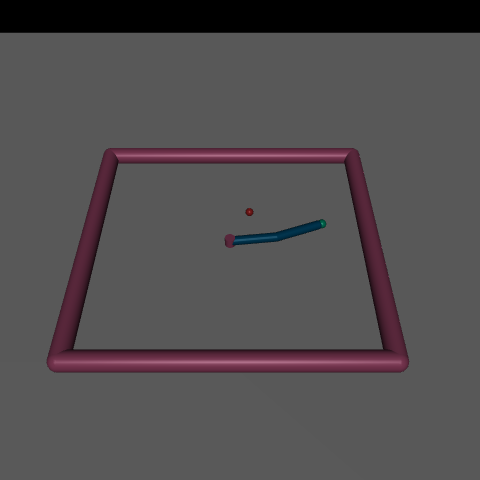

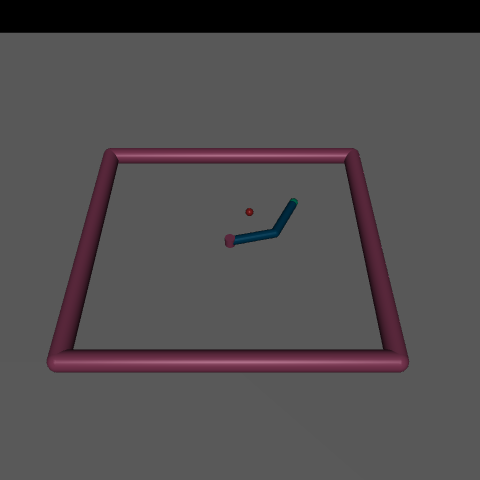

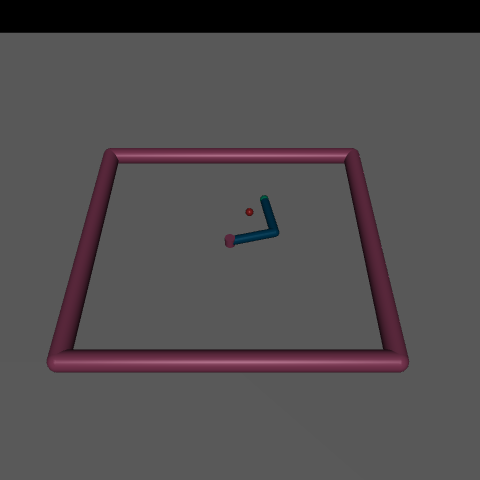

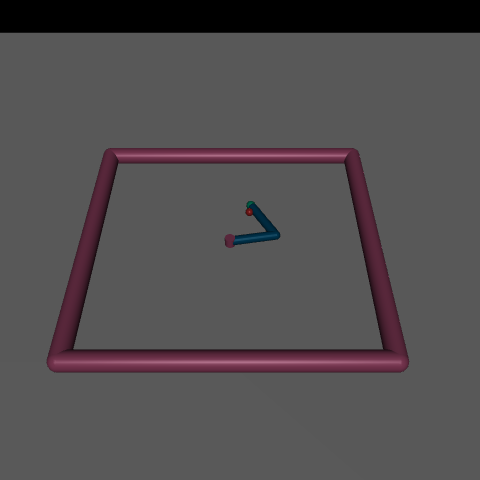

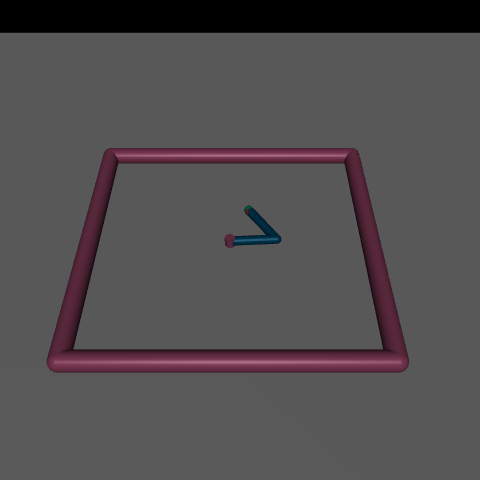

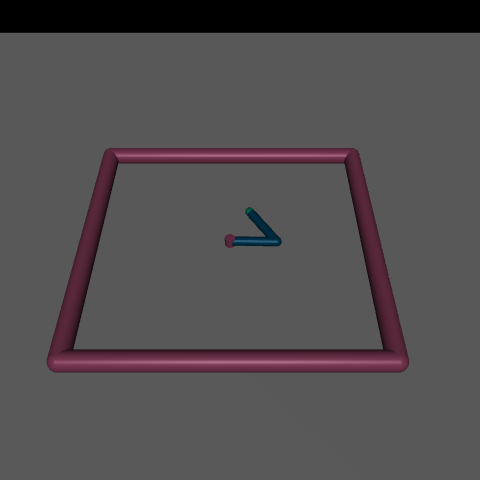

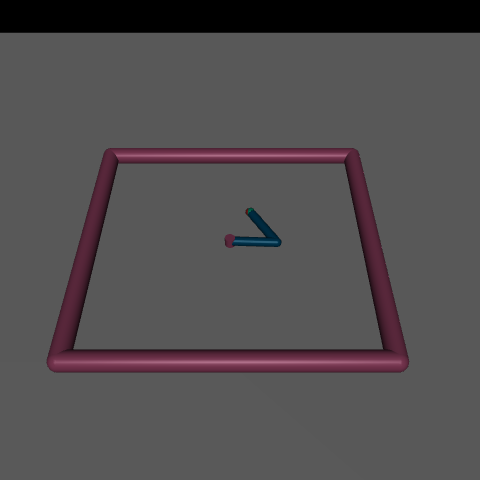

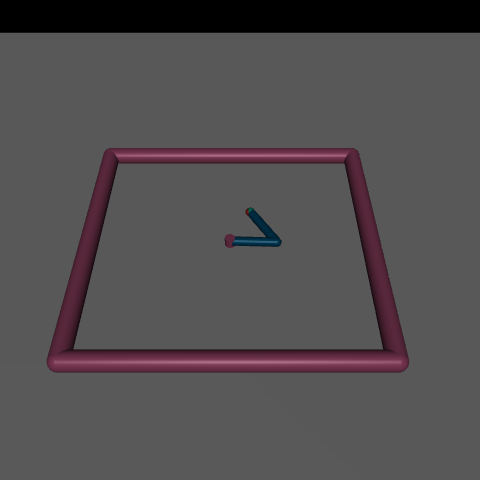

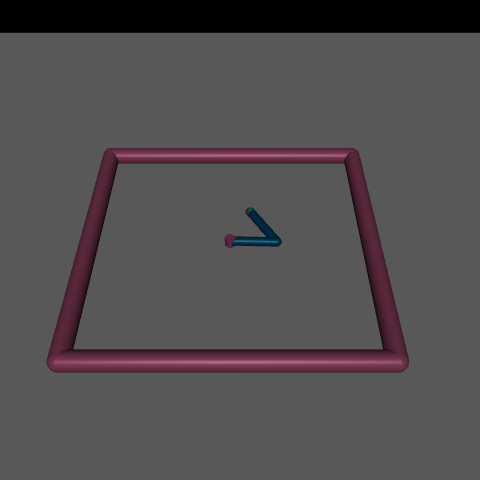

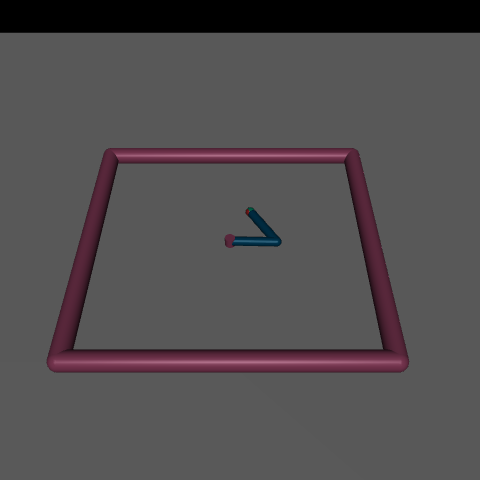

Mean of means: -0.05701756470943953


In [10]:
sim = Simulator(
        env_mode='reacher',
        net_type=net_type,
        path_to_model=path_to_model,
        n_episodes=n_episodes,
        render=render,
        video_saving=video_saving,
        device=device
    )
sim.run()